In [ ]:
# Домашнее задание выполнил Ионкин К.А.
# тема - Neural Style Transfer

In [4]:
import numpy as np
import scipy as sp

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import copy

import PIL
from PIL import Image
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [5]:
# Перенесем необходимый функцонал с  семинарского ноутбука

In [6]:
# естественно необохимо работат на GPU для ускорения процесса обучения
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [7]:
# перед подачей изображения в модель, необходимо произвести предобработку
imsize = 128  

loader = transforms.Compose([
    transforms.Resize(imsize), 
    transforms.CenterCrop(imsize),
    transforms.ToTensor()])

unloader = transforms.ToPILImage()

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

# функця отрисовки изображений
def imshow(tensor, title=None):
    image = tensor.cpu().clone()   
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    

In [8]:
# Загружаем фотки стилей и фотку контента
style1_img = image_loader("style1.jpg")
style2_img = image_loader("style2.jpg")
content_img = image_loader("face.jpg")



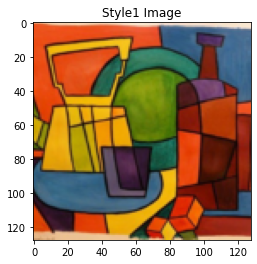

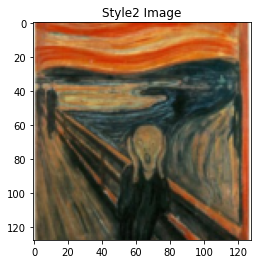

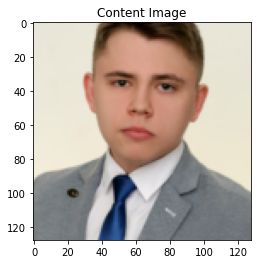

In [9]:
# и сразу же отобразим их

plt.figure()
imshow(style1_img, title='Style1 Image')

plt.figure()
imshow(style2_img, title='Style2 Image')

plt.figure()
imshow(content_img, title='Content Image')

In [10]:
# Создаем классы StyleLoss и ContentLoss

# класс ContentLoss остается без изменений
class ContentLoss(nn.Module):

        def __init__(self, target,):
            super(ContentLoss, self).__init__()
            # we 'detach' the target content from the tree used
            # to dynamically compute the gradient: this is a stated value,
            # not a variable. Otherwise the forward method of the criterion
            # will throw an error.
            self.target = target.detach()#это константа. Убираем ее из дерева вычеслений
            self.loss = F.mse_loss(self.target, self.target )#to initialize with something

        def forward(self, input_image):
            self.loss = F.mse_loss(input_image, self.target)
            
            return input_image

In [11]:
# функция получения матрицы грамма
def gram_matrix(input_image):
        batch_size, f_map_num, h, w  = input_image.size()  # batch size(=1)
        
        features = input_image.view(batch_size * f_map_num, h * w) 

        G = torch.mm(features, features.t())  # compute the gram product

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(batch_size * f_map_num * h * w)

In [42]:
# в классе StyleLoss расширяем функционал для различных вариантов применения 2 стилей(mode_split)
# Горизонтальное разделение и применение стилей к соответствующим областям
# Вертикальное разделение аналогично
# Оба стиля одновременно применяются ко всему изображению

class StyleLoss(nn.Module):
    """
    h - horizontal split
    V - vertical split
    both - both styles in the whole input_img
    """
    
    def __init__(self, target_feature, style, mode_split="h"):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        self.loss = F.mse_loss(self.target, self.target)
        self.mode_split = mode_split
        self.style = style

    def forward(self, input_image):
        
        mask_image = StyleLoss.split_dict[self.mode_split](self, input_image)
        
        G = gram_matrix(mask_image)
        self.loss = F.mse_loss(G, self.target)
        
        return input_image
    
    def horizontal_split(self, input_image):
        
        mask = torch.zeros_like(input_image)
        _, _, h, _ = mask.size()
        
        if self.style == "style1":
            mask[:, :, :h//2, :] +=1
            
        if self.style == "style2":
            mask[:, :, h//2:, :] +=1
        
        return input_image * mask
    
    def vertical_split(self, input_image):
        
        mask = torch.zeros_like(input_image)
        _, _, _, w = mask.size()
        
        if self.style == "style1":
            mask[:, :, :, :w//2] +=1
            
        if self.style == "style2":
            mask[:, :, :, w//2:] +=1
        
        return input_image * mask
    
    def both_split(self, input_image):
        return torch.clone(input_image)

    split_dict = {
        "h": horizontal_split,  
        "v": vertical_split,
        "both" : both_split
    }

In [13]:
content_layers_default = ['conv_4'] # слой для вывода content_loss
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5'] # слои для вывода соответствующего style_loss

In [14]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

In [15]:
class Normalization(nn.Module):
        def __init__(self, mean, std):
            super(Normalization, self).__init__()
            # .view the mean and std to make them [C x 1 x 1] so that they can
            # directly work with image Tensor of shape [B x C x H x W].
            # B is batch size. C is number of channels. H is height and W is width.
            self.mean = mean.view(-1, 1, 1)
            self.std = std.view(-1, 1, 1)

        def forward(self, img):
            # normalize img
            return (img - self.mean) / self.std

In [16]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [17]:
# Теперь в нашей модели подряд идут 2 слоя StyleLoss для каждого из стилей
def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                                   style1_img, style2_img, content_img, mode_split="h",
                                   content_layers=content_layers_default,
                                   style_layers=style_layers_default):
        cnn = copy.deepcopy(cnn)

        # normalization module
        normalization = Normalization(normalization_mean, normalization_std).to(device)

        # just in order to have an iterable access to or list of content/syle
        # losses
        content_losses = []
        style1_losses = []
        style2_losses = []

        # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
        # to put in modules that are supposed to be activated sequentially
        model = nn.Sequential(normalization) # мы создаем нашу модель на основе модели vgg19, но сначала нормализуем входный данные, так как в vgg19 поступают норм. данные

        i = 0  # increment every time we see a conv
        for layer in cnn.children():
            if isinstance(layer, nn.Conv2d):
                i += 1
                name = 'conv_{}'.format(i)
            elif isinstance(layer, nn.ReLU):
                name = 'relu_{}'.format(i)
                # The in-place version doesn't play very nicely with the ContentLoss
                # and StyleLoss we insert below. So we replace with out-of-place
                # ones here.
                #Переопределим relu уровень
                layer = nn.ReLU(inplace=False)
            elif isinstance(layer, nn.MaxPool2d):
                name = 'pool_{}'.format(i)
            elif isinstance(layer, nn.BatchNorm2d):
                name = 'bn_{}'.format(i)
            else:
                raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

            model.add_module(name, layer)

            if name in content_layers:
                # add content loss:
                target = model(content_img).detach()
                content_loss = ContentLoss(target)
                model.add_module("content_loss_{}".format(i), content_loss)
                content_losses.append(content_loss)

            if name in style_layers:
                # add style1 loss
                target1_feature = model(style1_img).detach()
                style1_loss = StyleLoss(target1_feature, mode_split, style="style1")
                model.add_module("style1_loss_{}".format(i), style1_loss)
                style1_losses.append(style1_loss)
                
                # add style2 loss
                target2_feature = model(style2_img).detach()
                style2_loss = StyleLoss(target2_feature, mode_split, style="style2")
                model.add_module("style2_loss_{}".format(i), style2_loss)
                style2_losses.append(style2_loss)

        # now we trim off the layers after the last content and style losses
        #выбрасываем все уровни после последенего style loss или content loss
        for i in range(len(model) - 1, -1, -1):
            if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
                break

        model = model[:(i + 1)]

        return model, style1_losses, style2_losses, content_losses

In [18]:
def get_input_optimizer(input_img):
        # this line to show that input is a parameter that requires a gradient
        #добоваляет содержимое тензора катринки в список изменяемых оптимизатором параметров
        optimizer = optim.LBFGS([input_img.requires_grad_()]) 
        return optimizer

In [19]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                        input_img, style1_img, style2_img, content_img, mode_split="h", num_steps=500,
                        style1_weight=1e4, style2_weight=1e4, content_weight=1):
        """Run the style transfer."""
        
        print('Building the style transfer model..')
        model, style1_losses, style2_losses, content_losses = get_style_model_and_losses(cnn,
            normalization_mean, normalization_std, style1_img, style2_img, content_img, mode_split)
        optimizer = get_input_optimizer(input_img)

        print('Optimizing..')
        run = [0]
        while run[0] <= num_steps:

            def closure():
                # correct the values 
                # это для того, чтобы значения тензора картинки не выходили за пределы [0;1]
                input_img.data.clamp_(0, 1)

                optimizer.zero_grad()

                model(input_img)

                style1_score = 0
                style2_score = 0
                content_score = 0

                for sl in style1_losses:
                    style1_score += sl.loss    
                for sl in style2_losses:
                    style2_score += sl.loss    
                for cl in content_losses:
                    content_score += cl.loss
                
                #взвешивание ощибки
                style1_score *= style1_weight
                style2_score *= style2_weight
                content_score *= content_weight

                loss = style1_score + style2_score + content_score
                loss.backward()

                run[0] += 1
                if run[0] % 100 == 0:
                    string_to_print = "run {} steps \n".format(run[0])
                    string_to_print += 'Style1 Loss: {:4f}  Style2 Loss: {:4f}  Content Loss: {:4f}'.format(
                        style1_score.item(), style2_score.item(), content_score.item())
                    #print("run {}:".format(run))
                    #print('Style1 Loss: {:4f}  Style2 Loss: {:4f}  Content Loss: {:4f}'.format(
                    #    style1_score.item(), style2_score.item(), content_score.item()))
                    #print()
                    plt.figure()
                    imshow(input_img, title=string_to_print)

                return loss

            optimizer.step(closure)

        # a last correction...
        input_img.data.clamp_(0, 1)

        return input_img

Building the style transfer model..
Optimizing..


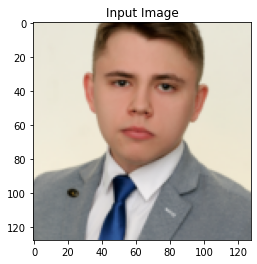

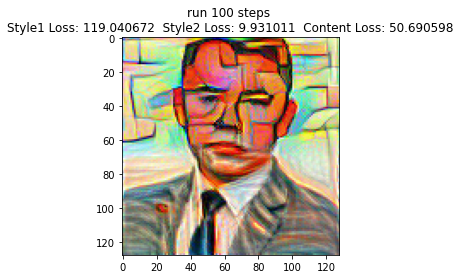

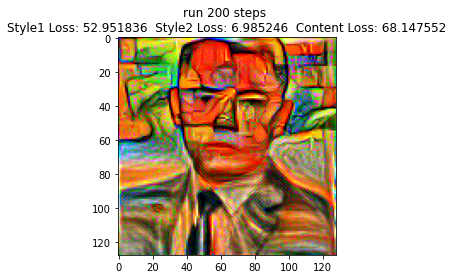

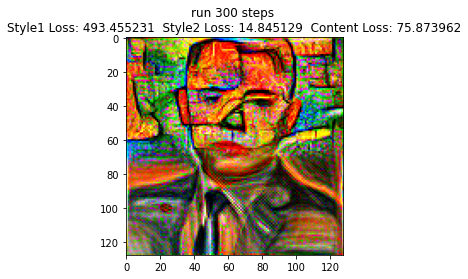

In [36]:
# Попробуем применить 2 стиля, разделяя границу стилей горизонтально(mode_split="h")

input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            input_img, style1_img, style2_img, content_img, mode_split="h", num_steps=300)

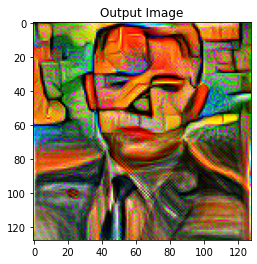

In [37]:
# конечный результат после 300 шагов построения изображения
plt.figure()
imshow(output, title='Output Image')

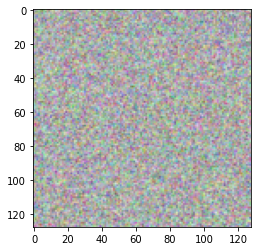

In [30]:
# Попробуем также построить изображение, где input_img - просто некоторый шум (mode_split="v")

input_img_new = image_loader("шум.jpg") 

imshow(input_img_new)

Building the style transfer model..
Optimizing..


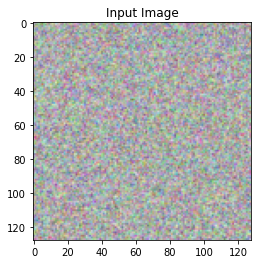

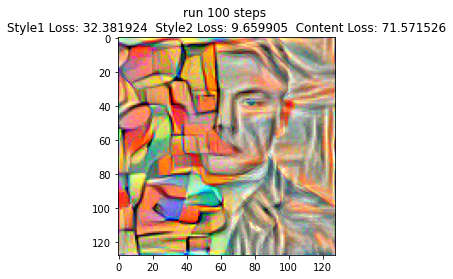

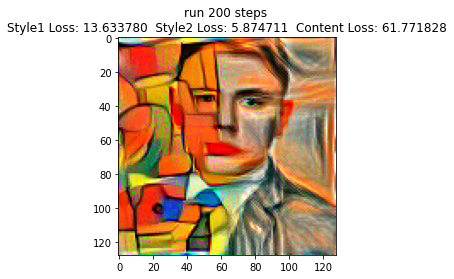

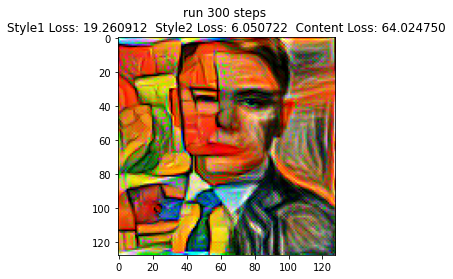

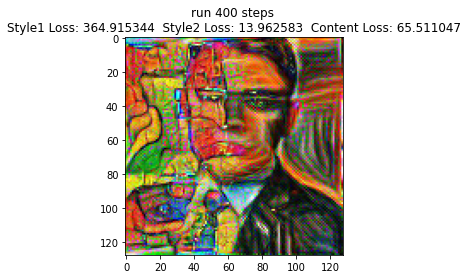

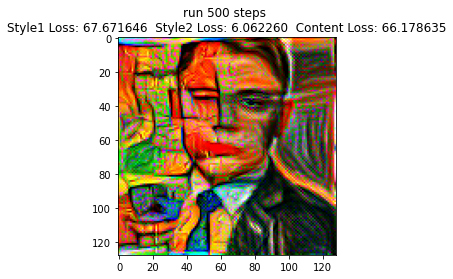

In [31]:
plt.figure()
imshow(input_img_new, title='Input Image')
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            input_img_new.clone(), style1_img, style2_img, content_img, mode_split="v", num_steps=500)

In [ ]:
# Как видно, из шума изображение также строится. Черты лица заметны и стили применяются к своим областям.
# Хотя визуально, если присмотреться, то можно заметить слабый шам, присутствующий на всех этапах построение изображения. Наиболее заметно слева, на светлом фоне.

# Визуально, мне больше импонируют изображения на первых шагах обучения.(Предполагаю, что это связано с соотношением стилей и светлого content_img)

Building the style transfer model..
Optimizing..


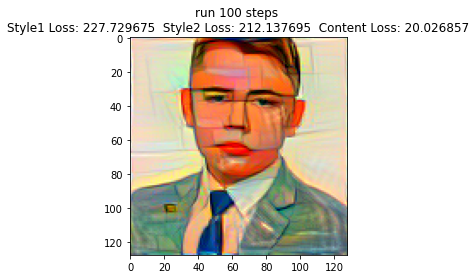

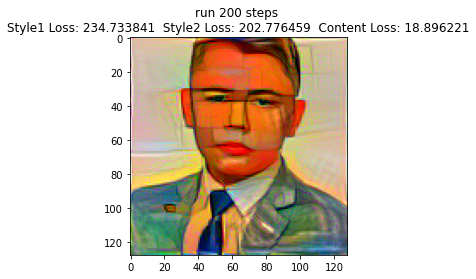

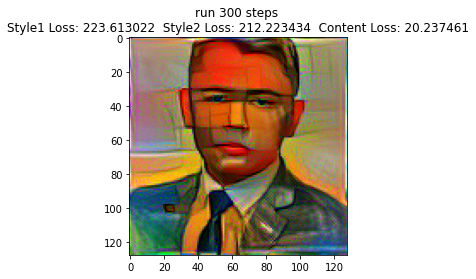

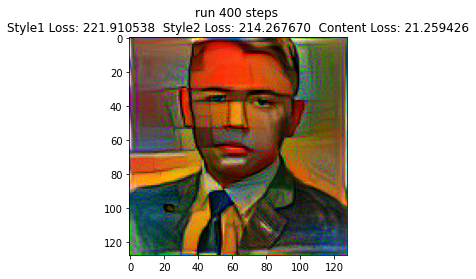

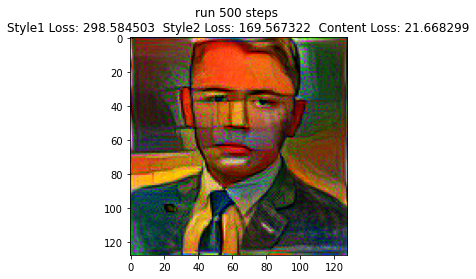

In [38]:
# Теперь попробуем применить оба стиля одновременно ко всему нашему изображению(mode_split = "both")

input_img_new2 = content_img.clone()
output_new2 = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            input_img_new2.clone(), style1_img, style2_img, content_img, mode_split="both", num_steps=500)

In [ ]:
# Замечу, что наиболее визуально приятные фотографии(при сочетании данных двух стилей и content_img) получаются на ранних шагах получения изображения.

# Так как хотелось бы более сильно проявить "мозаичность" первого стиля попробуем увеличить его вес.

Building the style transfer model..
Optimizing..


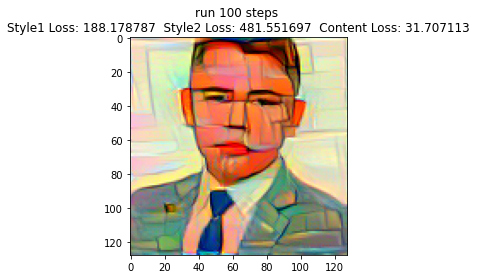

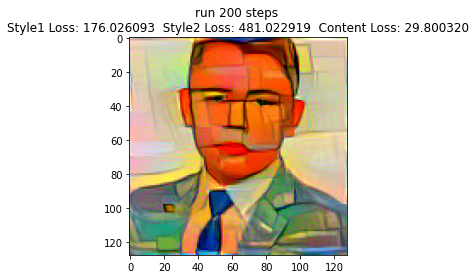

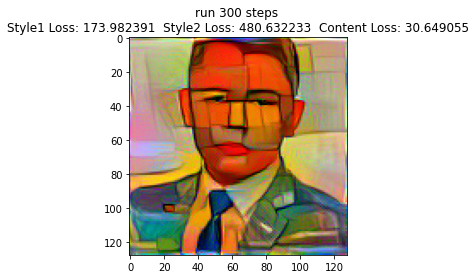

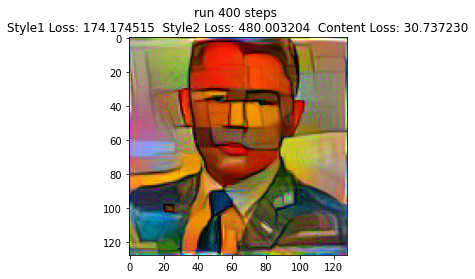

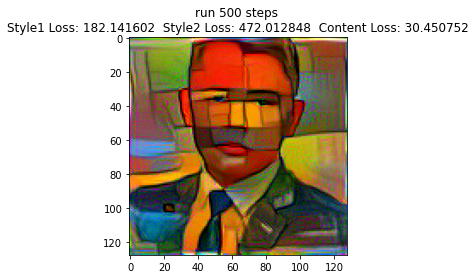

In [41]:
input_img_new3 = content_img.clone()
output_new3 = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            input_img_new2.clone(), style1_img, style2_img, content_img, mode_split="both", num_steps=500, style1_weight=3e4)

In [ ]:
# Действительно стала более сильно проявляться "мозаичность" 1ого стиля.
# Также хочется отметить, что для достижения более темного тона изображения(что соответствует 2ому стилю) требуется большее количество шагов, по сравнению
# с выделением фич - мозаичность, мазки, их комбинации. 

# Но, визуально, все равно мне больше нравятся изображения на первых шагах построения изображения.

# Также стоит отметить, что при длительном обучении замечается взрыв style_loss вне зависимости от режима наложения стилей на изображение(mode_split). При
# дальнейшем обучении обратное возвращение к визуально приятному состоянию уже не происходит и изображение портиться. Предполагаю, что оптимизатор все-же после взрыва style_loss
# остается в локальном минимуме и уже не может вернуться в более оптимальное положение.

# Также, если значение content_loss отстоит от изначального значения, которое получено при input_img = conten_loss.clone(), более чем на 20 единиц при content_weight=1, 
# то, черты лица заметно искажались за счет некоего шума поверх изображения(чаще зеленого, фиолетого отттенков) и визуально данное изображение выглядит не очень.